# Data

Only date, and maturities 1-20
- plot_data (1,2,3,4,...)
- data2 (SVENY01, SVENY02,...)

In [133]:
import pandas as pd

# Skip the first 9 rows
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter rows where Date is on or after 1985-01-02
data1 = data[data['Date'] >= '1985-01-02']
# List of columns to keep always
cols_to_keep = ['Date']

# Select columns that start with 'SVENY'
sveny_cols = [col for col in data.columns if col.startswith('SVENY')]

# Combine all columns to keep
all_keep_cols = cols_to_keep + sveny_cols

# Filter the dataframe to keep only these columns
data2 = data1[all_keep_cols]

# Check the result
data2.head()

# Drop SVENY21 to SVENY30 from data2
columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')


In [134]:
data2.shape

(10528, 21)

In [135]:
data2.columns

Index(['Date', 'SVENY01', 'SVENY02', 'SVENY03', 'SVENY04', 'SVENY05',
       'SVENY06', 'SVENY07', 'SVENY08', 'SVENY09', 'SVENY10', 'SVENY11',
       'SVENY12', 'SVENY13', 'SVENY14', 'SVENY15', 'SVENY16', 'SVENY17',
       'SVENY18', 'SVENY19', 'SVENY20'],
      dtype='object')

In [136]:
plot_data =data2

# Rename SVENY columns by stripping the prefix
plot_data.rename(columns=lambda col: col[5:] if col.startswith('SVENY') else col, inplace=True)

# Optional: convert new column names from strings like '01' to integers
plot_data.rename(columns=lambda col: str(int(col)) if col.isdigit() else col, inplace=True)

plot_data.columns

Index(['Date', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object')

In [138]:
data = data2.dropna()

split 

In [143]:
from datetime import date


data['Date'] = pd.to_datetime(data['Date']).dt.date
data1 = data[data['Date'] >= date(1985, 1, 2)] # Filter data from 1985-01-02 onwards
data2 = data1[data1['Date'] <= date(2025, 5, 1)] # Filter data up to 2025-05-01
valid = data[data['Date'] == date(2025, 5, 2)]

print(data1.shape)
print(data2.shape)
print(valid.shape)

(10073, 21)
(10067, 21)
(1, 21)


# Diffusion model

## Første model 

prepare data 

In [71]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

plot_data = plot_data.dropna()
# Extract yield values
yield_data = plot_data.loc[:, '1':'20'].values

# Normalize
scaler = StandardScaler()
normalized_data = scaler.fit_transform(yield_data)

plot_data.shape

(10073, 21)

Learning the model for diffusion 

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenoiseMLP(nn.Module):
    def __init__(self, input_dim):
        super(DenoiseMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, t):
        t = t.unsqueeze(1).float() / T
        x = torch.cat([x, t], dim=1)
        return self.model(x)

Training the model

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# === Load & normalize data ===
df = plot_data
yield_data = df.loc[:, '1':'20'].values.astype(np.float32)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(yield_data)

X = torch.tensor(normalized_data, dtype=torch.float32)

# === Diffusion setup ===
T = 1000
betas = torch.linspace(1e-4, 0.02, T, dtype=torch.float32)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)
alpha_bars = torch.clamp(alpha_bars, min=1e-5)  # avoids division by zero

# === Model ===
class DenoiseMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, t):
        t = t.unsqueeze(1).float() / T
        x = torch.cat([x, t], dim=1)
        return self.model(x)

model = DenoiseMLP(input_dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Training ===
batch_size = 64
num_epochs = 1000

for epoch in range(num_epochs):
    idx = torch.randint(0, X.shape[0], (batch_size,))
    x0 = X[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x0)

    ab = alpha_bars[t].unsqueeze(1)
    xt = torch.sqrt(ab) * x0 + torch.sqrt(1 - ab) * noise
    xt = torch.clamp(xt, -5, 5)  # avoid large values

    pred = model(xt, t)
    loss = F.mse_loss(pred, noise)

    if torch.isnan(loss):
        print("Loss is NaN. Check values:")
        print("xt stats:", xt.mean().item(), xt.std().item())
        break

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 1.025621
Epoch 100: Loss = 0.866977
Epoch 200: Loss = 0.814953
Epoch 300: Loss = 0.634897
Epoch 400: Loss = 0.492763
Epoch 500: Loss = 0.434525
Epoch 600: Loss = 0.285074
Epoch 700: Loss = 0.155341
Epoch 800: Loss = 0.213401
Epoch 900: Loss = 0.202791


In [74]:
@torch.no_grad()
def sample(model, n_samples=1, input_dim=20):
    x = torch.randn(n_samples, input_dim)
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, dtype=torch.long)
        z = torch.randn_like(x) if t > 0 else 0
        alpha_bar = alpha_bars[t]
        beta = betas[t]

        pred_noise = model(x, t_batch)
        x = (1 / torch.sqrt(alphas[t])) * (x - (1 - alphas[t]) / torch.sqrt(1 - alpha_bar) * pred_noise) + torch.sqrt(beta) * z
        x = torch.clamp(x, -5, 5)
    return x

In [75]:
samples = sample(model, n_samples=10)
samples_np = scaler.inverse_transform(samples.numpy())

## Anden model

### Sample random yield curve


In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# === Load and preprocess ===
yield_data = plot_data.loc[:, '1':'20'].values.astype(np.float32)  # drop date

# Standardize yield curves (zero mean, unit variance per maturity)
scaler = StandardScaler()
yield_data = scaler.fit_transform(yield_data)
X = torch.tensor(yield_data, dtype=torch.float32)

# === Diffusion Parameters ===
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# === Define MLP Model ===
class DenoiseMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
        )

    def forward(self, x, t):
        t = t.unsqueeze(1).float() / T
        x_in = torch.cat([x, t], dim=1)
        return self.model(x_in)

model = DenoiseMLP(dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

# === Noise sampling function ===
def q_sample(x0, t, noise):
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bars[t])[:, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

# === Training Loop ===
epochs = 100000
batch_size = 128

for epoch in tqdm(range(epochs)):
    idx = torch.randint(0, X.shape[0], (batch_size,))
    x0 = X[idx]
    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred = model(xt, t)
    loss = F.mse_loss(pred, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# === Sampling function to generate new curves ===
@torch.no_grad()
def sample(model, n=1):
    x = torch.randn(n, 20)
    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, dtype=torch.long)
        pred_noise = model(x, t_tensor)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        # Prevent division by zero or very small values
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(torch.clamp(1 - alpha_bar_t, min=1e-5))
        sqrt_beta_t = torch.sqrt(beta_t)

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / sqrt_alpha_t) * (x - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise) + sqrt_beta_t * noise

    return scaler.inverse_transform(x.numpy())
# === Generate and print a new yield curve ===
new_curve = sample(model, n=1)
print("Generated yield curve:", new_curve)

  0%|          | 310/100000 [00:00<01:01, 1626.79it/s]

Epoch 0 | Loss: 1.0416


  1%|          | 747/100000 [00:00<00:49, 2001.94it/s]

Epoch 500 | Loss: 0.2556


  1%|▏         | 1376/100000 [00:00<00:47, 2075.31it/s]

Epoch 1000 | Loss: 0.2004


  2%|▏         | 1791/100000 [00:00<00:54, 1801.95it/s]

Epoch 1500 | Loss: 0.1481


  2%|▏         | 2437/100000 [00:01<00:48, 2030.43it/s]

Epoch 2000 | Loss: 0.1553


  3%|▎         | 2857/100000 [00:01<00:47, 2062.51it/s]

Epoch 2500 | Loss: 0.1416


  3%|▎         | 3283/100000 [00:01<00:46, 2096.55it/s]

Epoch 3000 | Loss: 0.1490


  4%|▍         | 3923/100000 [00:01<00:45, 2113.82it/s]

Epoch 3500 | Loss: 0.1073


  4%|▍         | 4347/100000 [00:02<00:45, 2107.61it/s]

Epoch 4000 | Loss: 0.1158


  5%|▍         | 4789/100000 [00:02<00:44, 2162.29it/s]

Epoch 4500 | Loss: 0.1200


  5%|▌         | 5240/100000 [00:02<00:42, 2206.94it/s]

Epoch 5000 | Loss: 0.1440


  6%|▌         | 5913/100000 [00:02<00:43, 2171.81it/s]

Epoch 5500 | Loss: 0.0915


  6%|▋         | 6352/100000 [00:03<00:43, 2160.23it/s]

Epoch 6000 | Loss: 0.0981


  7%|▋         | 6782/100000 [00:03<00:47, 1952.24it/s]

Epoch 6500 | Loss: 0.0802


  7%|▋         | 7232/100000 [00:03<00:44, 2093.52it/s]

Epoch 7000 | Loss: 0.1107


  8%|▊         | 7914/100000 [00:03<00:41, 2205.89it/s]

Epoch 7500 | Loss: 0.1238


  8%|▊         | 8354/100000 [00:04<00:42, 2140.16it/s]

Epoch 8000 | Loss: 0.1232


  9%|▉         | 8782/100000 [00:04<00:44, 2058.91it/s]

Epoch 8500 | Loss: 0.1085


  9%|▉         | 9217/100000 [00:04<00:42, 2111.71it/s]

Epoch 9000 | Loss: 0.1116


 10%|▉         | 9879/100000 [00:04<00:41, 2180.68it/s]

Epoch 9500 | Loss: 0.1215


 10%|█         | 10345/100000 [00:04<00:39, 2254.26it/s]

Epoch 10000 | Loss: 0.0950


 11%|█         | 10805/100000 [00:05<00:39, 2279.89it/s]

Epoch 10500 | Loss: 0.0839


 11%|█▏        | 11269/100000 [00:05<00:39, 2218.99it/s]

Epoch 11000 | Loss: 0.1124


 12%|█▏        | 11703/100000 [00:05<00:42, 2073.97it/s]

Epoch 11500 | Loss: 0.1062


 12%|█▏        | 12114/100000 [00:05<00:53, 1653.23it/s]

Epoch 12000 | Loss: 0.0688


 13%|█▎        | 12836/100000 [00:06<00:50, 1740.82it/s]

Epoch 12500 | Loss: 0.0644


 13%|█▎        | 13257/100000 [00:06<00:45, 1917.37it/s]

Epoch 13000 | Loss: 0.0792


 14%|█▍        | 13900/100000 [00:06<00:41, 2054.68it/s]

Epoch 13500 | Loss: 0.1010


 14%|█▍        | 14318/100000 [00:06<00:41, 2065.45it/s]

Epoch 14000 | Loss: 0.0637


 15%|█▍        | 14759/100000 [00:07<00:40, 2103.94it/s]

Epoch 14500 | Loss: 0.0732


 15%|█▌        | 15374/100000 [00:07<00:43, 1951.39it/s]

Epoch 15000 | Loss: 0.0843


 16%|█▌        | 15823/100000 [00:07<00:40, 2103.18it/s]

Epoch 15500 | Loss: 0.0879


 16%|█▋        | 16291/100000 [00:07<00:37, 2221.38it/s]

Epoch 16000 | Loss: 0.1106


 17%|█▋        | 16759/100000 [00:08<00:36, 2277.81it/s]

Epoch 16500 | Loss: 0.0774


 17%|█▋        | 17465/100000 [00:08<00:35, 2324.61it/s]

Epoch 17000 | Loss: 0.0572


 18%|█▊        | 17931/100000 [00:08<00:39, 2103.31it/s]

Epoch 17500 | Loss: 0.0827


 18%|█▊        | 18394/100000 [00:08<00:36, 2206.26it/s]

Epoch 18000 | Loss: 0.0634


 19%|█▉        | 18860/100000 [00:09<00:35, 2266.89it/s]

Epoch 18500 | Loss: 0.0682


 19%|█▉        | 19329/100000 [00:09<00:34, 2305.90it/s]

Epoch 19000 | Loss: 0.0641


 20%|█▉        | 19796/100000 [00:09<00:34, 2318.00it/s]

Epoch 19500 | Loss: 0.0751


 20%|██        | 20264/100000 [00:09<00:34, 2322.12it/s]

Epoch 20000 | Loss: 0.0780


 21%|██        | 20969/100000 [00:09<00:33, 2337.34it/s]

Epoch 20500 | Loss: 0.0762


 21%|██▏       | 21439/100000 [00:10<00:33, 2340.34it/s]

Epoch 21000 | Loss: 0.0622


 22%|██▏       | 21911/100000 [00:10<00:33, 2342.83it/s]

Epoch 21500 | Loss: 0.0677


 22%|██▏       | 22383/100000 [00:10<00:33, 2349.06it/s]

Epoch 22000 | Loss: 0.0753


 23%|██▎       | 22854/100000 [00:10<00:32, 2346.50it/s]

Epoch 22500 | Loss: 0.0705


 23%|██▎       | 23324/100000 [00:10<00:32, 2336.78it/s]

Epoch 23000 | Loss: 0.0647


 24%|██▍       | 23795/100000 [00:11<00:32, 2335.17it/s]

Epoch 23500 | Loss: 0.0665


 24%|██▍       | 24264/100000 [00:11<00:32, 2339.68it/s]

Epoch 24000 | Loss: 0.0576


 25%|██▍       | 24970/100000 [00:11<00:31, 2349.11it/s]

Epoch 24500 | Loss: 0.0542


 25%|██▌       | 25442/100000 [00:11<00:31, 2346.93it/s]

Epoch 25000 | Loss: 0.0712


 26%|██▌       | 25915/100000 [00:12<00:31, 2345.31it/s]

Epoch 25500 | Loss: 0.0683


 26%|██▋       | 26384/100000 [00:12<00:31, 2337.67it/s]

Epoch 26000 | Loss: 0.0461


 27%|██▋       | 26854/100000 [00:12<00:31, 2338.78it/s]

Epoch 26500 | Loss: 0.0627


 27%|██▋       | 27325/100000 [00:12<00:30, 2345.58it/s]

Epoch 27000 | Loss: 0.0546


 28%|██▊       | 27796/100000 [00:12<00:30, 2347.62it/s]

Epoch 27500 | Loss: 0.0754


 28%|██▊       | 28268/100000 [00:13<00:30, 2351.26it/s]

Epoch 28000 | Loss: 0.0472


 29%|██▊       | 28740/100000 [00:13<00:30, 2346.01it/s]

Epoch 28500 | Loss: 0.0743


 29%|██▉       | 29449/100000 [00:13<00:30, 2351.53it/s]

Epoch 29000 | Loss: 0.0816


 30%|██▉       | 29922/100000 [00:13<00:29, 2353.30it/s]

Epoch 29500 | Loss: 0.0461


 30%|███       | 30393/100000 [00:14<00:29, 2346.96it/s]

Epoch 30000 | Loss: 0.0561


 31%|███       | 30865/100000 [00:14<00:29, 2352.89it/s]

Epoch 30500 | Loss: 0.0624


 31%|███▏      | 31336/100000 [00:14<00:33, 2069.69it/s]

Epoch 31000 | Loss: 0.0653


 32%|███▏      | 31802/100000 [00:14<00:31, 2192.92it/s]

Epoch 31500 | Loss: 0.0639


 32%|███▏      | 32269/100000 [00:14<00:29, 2262.93it/s]

Epoch 32000 | Loss: 0.0615


 33%|███▎      | 32970/100000 [00:15<00:29, 2310.46it/s]

Epoch 32500 | Loss: 0.0640


 33%|███▎      | 33440/100000 [00:15<00:28, 2329.47it/s]

Epoch 33000 | Loss: 0.0722


 34%|███▍      | 33911/100000 [00:15<00:28, 2341.04it/s]

Epoch 33500 | Loss: 0.0661


 34%|███▍      | 34383/100000 [00:15<00:27, 2346.61it/s]

Epoch 34000 | Loss: 0.0605


 35%|███▍      | 34853/100000 [00:15<00:27, 2343.89it/s]

Epoch 34500 | Loss: 0.0544


 35%|███▌      | 35326/100000 [00:16<00:27, 2353.48it/s]

Epoch 35000 | Loss: 0.0733


 36%|███▌      | 35797/100000 [00:16<00:27, 2347.12it/s]

Epoch 35500 | Loss: 0.0702


 36%|███▋      | 36268/100000 [00:16<00:27, 2345.95it/s]

Epoch 36000 | Loss: 0.0860


 37%|███▋      | 36738/100000 [00:16<00:27, 2339.00it/s]

Epoch 36500 | Loss: 0.0729


 37%|███▋      | 37445/100000 [00:17<00:26, 2344.64it/s]

Epoch 37000 | Loss: 0.0472


 38%|███▊      | 37916/100000 [00:17<00:26, 2348.07it/s]

Epoch 37500 | Loss: 0.0475


 38%|███▊      | 38388/100000 [00:17<00:26, 2349.83it/s]

Epoch 38000 | Loss: 0.0588


 39%|███▉      | 38862/100000 [00:17<00:25, 2353.83it/s]

Epoch 38500 | Loss: 0.0591


 39%|███▉      | 39335/100000 [00:17<00:25, 2355.05it/s]

Epoch 39000 | Loss: 0.0685


 40%|███▉      | 39807/100000 [00:18<00:25, 2349.34it/s]

Epoch 39500 | Loss: 0.0703


 40%|████      | 40279/100000 [00:18<00:25, 2349.79it/s]

Epoch 40000 | Loss: 0.0683


 41%|████      | 40750/100000 [00:18<00:25, 2343.87it/s]

Epoch 40500 | Loss: 0.0713


 41%|████▏     | 41459/100000 [00:18<00:24, 2349.20it/s]

Epoch 41000 | Loss: 0.0747


 42%|████▏     | 41930/100000 [00:18<00:24, 2348.08it/s]

Epoch 41500 | Loss: 0.0650


 42%|████▏     | 42403/100000 [00:19<00:24, 2351.93it/s]

Epoch 42000 | Loss: 0.0544


 43%|████▎     | 42877/100000 [00:19<00:24, 2356.08it/s]

Epoch 42500 | Loss: 0.0619


 43%|████▎     | 43349/100000 [00:19<00:24, 2354.81it/s]

Epoch 43000 | Loss: 0.0574


 44%|████▍     | 43823/100000 [00:19<00:23, 2358.93it/s]

Epoch 43500 | Loss: 0.0599


 44%|████▍     | 44295/100000 [00:19<00:23, 2348.35it/s]

Epoch 44000 | Loss: 0.0603


 45%|████▍     | 44765/100000 [00:20<00:26, 2089.62it/s]

Epoch 44500 | Loss: 0.0686


 45%|████▌     | 45235/100000 [00:20<00:24, 2212.01it/s]

Epoch 45000 | Loss: 0.0616


 46%|████▌     | 45941/100000 [00:20<00:23, 2299.17it/s]

Epoch 45500 | Loss: 0.0439


 46%|████▋     | 46416/100000 [00:20<00:22, 2333.64it/s]

Epoch 46000 | Loss: 0.0586


 47%|████▋     | 46888/100000 [00:21<00:22, 2343.72it/s]

Epoch 46500 | Loss: 0.0456


 47%|████▋     | 47359/100000 [00:21<00:22, 2343.33it/s]

Epoch 47000 | Loss: 0.0549


 48%|████▊     | 47831/100000 [00:21<00:22, 2344.95it/s]

Epoch 47500 | Loss: 0.0524


 48%|████▊     | 48301/100000 [00:21<00:22, 2339.61it/s]

Epoch 48000 | Loss: 0.0615


 49%|████▉     | 48772/100000 [00:21<00:21, 2344.64it/s]

Epoch 48500 | Loss: 0.0435


 49%|████▉     | 49246/100000 [00:22<00:21, 2354.32it/s]

Epoch 49000 | Loss: 0.0487


 50%|████▉     | 49955/100000 [00:22<00:21, 2348.52it/s]

Epoch 49500 | Loss: 0.0755


 50%|█████     | 50425/100000 [00:22<00:21, 2343.76it/s]

Epoch 50000 | Loss: 0.0682


 51%|█████     | 50895/100000 [00:22<00:21, 2333.23it/s]

Epoch 50500 | Loss: 0.0579


 51%|█████▏    | 51365/100000 [00:23<00:20, 2338.07it/s]

Epoch 51000 | Loss: 0.0510


 52%|█████▏    | 51838/100000 [00:23<00:20, 2349.43it/s]

Epoch 51500 | Loss: 0.0890


 52%|█████▏    | 52313/100000 [00:23<00:20, 2363.41it/s]

Epoch 52000 | Loss: 0.0503


 53%|█████▎    | 52786/100000 [00:23<00:20, 2349.80it/s]

Epoch 52500 | Loss: 0.0540


 53%|█████▎    | 53259/100000 [00:23<00:19, 2354.57it/s]

Epoch 53000 | Loss: 0.0514


 54%|█████▍    | 53970/100000 [00:24<00:19, 2359.92it/s]

Epoch 53500 | Loss: 0.0661


 54%|█████▍    | 54442/100000 [00:24<00:19, 2347.35it/s]

Epoch 54000 | Loss: 0.0568


 55%|█████▍    | 54914/100000 [00:24<00:19, 2346.76it/s]

Epoch 54500 | Loss: 0.0569


 55%|█████▌    | 55385/100000 [00:24<00:19, 2345.08it/s]

Epoch 55000 | Loss: 0.0487


 56%|█████▌    | 55862/100000 [00:24<00:18, 2361.04it/s]

Epoch 55500 | Loss: 0.0817


 56%|█████▋    | 56336/100000 [00:25<00:18, 2359.46it/s]

Epoch 56000 | Loss: 0.0431


 57%|█████▋    | 56809/100000 [00:25<00:18, 2358.61it/s]

Epoch 56500 | Loss: 0.0588


 57%|█████▋    | 57281/100000 [00:25<00:19, 2156.14it/s]

Epoch 57000 | Loss: 0.0591


 58%|█████▊    | 57751/100000 [00:25<00:18, 2249.15it/s]

Epoch 57500 | Loss: 0.0694


 58%|█████▊    | 58461/100000 [00:26<00:17, 2325.12it/s]

Epoch 58000 | Loss: 0.0541


 59%|█████▉    | 58934/100000 [00:26<00:17, 2345.05it/s]

Epoch 58500 | Loss: 0.0564


 59%|█████▉    | 59406/100000 [00:26<00:17, 2343.06it/s]

Epoch 59000 | Loss: 0.0550


 60%|█████▉    | 59879/100000 [00:26<00:17, 2351.88it/s]

Epoch 59500 | Loss: 0.0576


 60%|██████    | 60353/100000 [00:26<00:16, 2360.13it/s]

Epoch 60000 | Loss: 0.0483


 61%|██████    | 60826/100000 [00:27<00:16, 2351.80it/s]

Epoch 60500 | Loss: 0.0454


 61%|██████▏   | 61299/100000 [00:27<00:16, 2351.37it/s]

Epoch 61000 | Loss: 0.0566


 62%|██████▏   | 61772/100000 [00:27<00:16, 2346.28it/s]

Epoch 61500 | Loss: 0.0508


 62%|██████▏   | 62243/100000 [00:27<00:16, 2348.77it/s]

Epoch 62000 | Loss: 0.0496


 63%|██████▎   | 62952/100000 [00:28<00:15, 2358.11it/s]

Epoch 62500 | Loss: 0.0500


 63%|██████▎   | 63424/100000 [00:28<00:15, 2349.85it/s]

Epoch 63000 | Loss: 0.0625


 64%|██████▍   | 63893/100000 [00:28<00:15, 2329.43it/s]

Epoch 63500 | Loss: 0.0457


 64%|██████▍   | 64364/100000 [00:28<00:15, 2342.50it/s]

Epoch 64000 | Loss: 0.0485


 65%|██████▍   | 64834/100000 [00:28<00:15, 2342.51it/s]

Epoch 64500 | Loss: 0.0655


 65%|██████▌   | 65305/100000 [00:29<00:14, 2344.88it/s]

Epoch 65000 | Loss: 0.0465


 66%|██████▌   | 65777/100000 [00:29<00:14, 2349.96it/s]

Epoch 65500 | Loss: 0.0615


 66%|██████▋   | 66251/100000 [00:29<00:14, 2356.89it/s]

Epoch 66000 | Loss: 0.0589


 67%|██████▋   | 66965/100000 [00:29<00:13, 2370.49it/s]

Epoch 66500 | Loss: 0.0509


 67%|██████▋   | 67440/100000 [00:29<00:13, 2361.17it/s]

Epoch 67000 | Loss: 0.0481


 68%|██████▊   | 67913/100000 [00:30<00:13, 2345.21it/s]

Epoch 67500 | Loss: 0.0474


 68%|██████▊   | 68385/100000 [00:30<00:13, 2350.67it/s]

Epoch 68000 | Loss: 0.0580


 69%|██████▉   | 68856/100000 [00:30<00:13, 2346.04it/s]

Epoch 68500 | Loss: 0.0641


 69%|██████▉   | 69329/100000 [00:30<00:13, 2353.35it/s]

Epoch 69000 | Loss: 0.0533


 70%|██████▉   | 69801/100000 [00:30<00:12, 2350.28it/s]

Epoch 69500 | Loss: 0.0522


 70%|███████   | 70269/100000 [00:31<00:13, 2139.54it/s]

Epoch 70000 | Loss: 0.0350


 71%|███████   | 70739/100000 [00:31<00:13, 2240.39it/s]

Epoch 70500 | Loss: 0.0393


 71%|███████▏  | 71447/100000 [00:31<00:12, 2316.84it/s]

Epoch 71000 | Loss: 0.0444


 72%|███████▏  | 71918/100000 [00:31<00:12, 2335.35it/s]

Epoch 71500 | Loss: 0.0548


 72%|███████▏  | 72390/100000 [00:32<00:11, 2348.13it/s]

Epoch 72000 | Loss: 0.0710


 73%|███████▎  | 72862/100000 [00:32<00:11, 2347.84it/s]

Epoch 72500 | Loss: 0.0589


 73%|███████▎  | 73332/100000 [00:32<00:11, 2331.96it/s]

Epoch 73000 | Loss: 0.0470


 74%|███████▍  | 73802/100000 [00:32<00:11, 2337.95it/s]

Epoch 73500 | Loss: 0.0525


 74%|███████▍  | 74273/100000 [00:32<00:10, 2341.96it/s]

Epoch 74000 | Loss: 0.0491


 75%|███████▍  | 74746/100000 [00:33<00:10, 2350.12it/s]

Epoch 74500 | Loss: 0.0526


 75%|███████▌  | 75457/100000 [00:33<00:10, 2360.85it/s]

Epoch 75000 | Loss: 0.0419


 76%|███████▌  | 75932/100000 [00:33<00:10, 2360.58it/s]

Epoch 75500 | Loss: 0.0472


 76%|███████▋  | 76405/100000 [00:33<00:10, 2352.94it/s]

Epoch 76000 | Loss: 0.0498


 77%|███████▋  | 76876/100000 [00:33<00:09, 2344.34it/s]

Epoch 76500 | Loss: 0.0578


 77%|███████▋  | 77347/100000 [00:34<00:09, 2347.93it/s]

Epoch 77000 | Loss: 0.0497


 78%|███████▊  | 77817/100000 [00:34<00:09, 2348.31it/s]

Epoch 77500 | Loss: 0.0482


 78%|███████▊  | 78288/100000 [00:34<00:09, 2347.75it/s]

Epoch 78000 | Loss: 0.0541


 79%|███████▉  | 78761/100000 [00:34<00:09, 2353.22it/s]

Epoch 78500 | Loss: 0.0450


 79%|███████▉  | 79475/100000 [00:35<00:08, 2369.39it/s]

Epoch 79000 | Loss: 0.0535


 80%|███████▉  | 79949/100000 [00:35<00:08, 2363.21it/s]

Epoch 79500 | Loss: 0.0465


 80%|████████  | 80423/100000 [00:35<00:08, 2359.32it/s]

Epoch 80000 | Loss: 0.0473


 81%|████████  | 80894/100000 [00:35<00:08, 2331.15it/s]

Epoch 80500 | Loss: 0.0353


 81%|████████▏ | 81364/100000 [00:35<00:07, 2335.18it/s]

Epoch 81000 | Loss: 0.0552


 82%|████████▏ | 81832/100000 [00:36<00:08, 2140.11it/s]

Epoch 81500 | Loss: 0.0600


 82%|████████▏ | 82291/100000 [00:36<00:07, 2217.40it/s]

Epoch 82000 | Loss: 0.0542


 83%|████████▎ | 82765/100000 [00:36<00:07, 2290.99it/s]

Epoch 82500 | Loss: 0.0510


 83%|████████▎ | 83239/100000 [00:36<00:07, 2327.48it/s]

Epoch 83000 | Loss: 0.0432


 84%|████████▍ | 83954/100000 [00:37<00:06, 2362.29it/s]

Epoch 83500 | Loss: 0.0481


 84%|████████▍ | 84427/100000 [00:37<00:06, 2354.70it/s]

Epoch 84000 | Loss: 0.0370


 85%|████████▍ | 84899/100000 [00:37<00:06, 2354.07it/s]

Epoch 84500 | Loss: 0.0474


 85%|████████▌ | 85371/100000 [00:37<00:06, 2349.97it/s]

Epoch 85000 | Loss: 0.0509


 86%|████████▌ | 85844/100000 [00:37<00:06, 2352.02it/s]

Epoch 85500 | Loss: 0.0618


 86%|████████▋ | 86316/100000 [00:38<00:05, 2345.79it/s]

Epoch 86000 | Loss: 0.0521


 87%|████████▋ | 86789/100000 [00:38<00:05, 2353.06it/s]

Epoch 86500 | Loss: 0.0563


 87%|████████▋ | 87262/100000 [00:38<00:05, 2348.47it/s]

Epoch 87000 | Loss: 0.0537


 88%|████████▊ | 87971/100000 [00:38<00:05, 2355.80it/s]

Epoch 87500 | Loss: 0.0535


 88%|████████▊ | 88444/100000 [00:38<00:04, 2357.74it/s]

Epoch 88000 | Loss: 0.0386


 89%|████████▉ | 88917/100000 [00:39<00:04, 2354.16it/s]

Epoch 88500 | Loss: 0.0406


 89%|████████▉ | 89390/100000 [00:39<00:04, 2356.04it/s]

Epoch 89000 | Loss: 0.0745


 90%|████████▉ | 89865/100000 [00:39<00:04, 2360.78it/s]

Epoch 89500 | Loss: 0.0393


 90%|█████████ | 90338/100000 [00:39<00:04, 2354.95it/s]

Epoch 90000 | Loss: 0.0499


 91%|█████████ | 90813/100000 [00:39<00:03, 2356.09it/s]

Epoch 90500 | Loss: 0.0423


 91%|█████████▏| 91285/100000 [00:40<00:03, 2355.26it/s]

Epoch 91000 | Loss: 0.0423


 92%|█████████▏| 91758/100000 [00:40<00:03, 2356.64it/s]

Epoch 91500 | Loss: 0.0446


 92%|█████████▏| 92232/100000 [00:40<00:03, 2359.94it/s]

Epoch 92000 | Loss: 0.0449


 93%|█████████▎| 92931/100000 [00:40<00:03, 2241.68it/s]

Epoch 92500 | Loss: 0.0495


 93%|█████████▎| 93370/100000 [00:41<00:03, 2034.27it/s]

Epoch 93000 | Loss: 0.0463


 94%|█████████▍| 93801/100000 [00:41<00:02, 2090.61it/s]

Epoch 93500 | Loss: 0.0564


 94%|█████████▍| 94219/100000 [00:41<00:04, 1407.67it/s]

Epoch 94000 | Loss: 0.0531


 95%|█████████▍| 94854/100000 [00:42<00:02, 1795.44it/s]

Epoch 94500 | Loss: 0.0438


 95%|█████████▌| 95249/100000 [00:42<00:02, 1806.70it/s]

Epoch 95000 | Loss: 0.0452


 96%|█████████▌| 95879/100000 [00:42<00:02, 1988.04it/s]

Epoch 95500 | Loss: 0.0548


 96%|█████████▋| 96306/100000 [00:42<00:01, 2066.27it/s]

Epoch 96000 | Loss: 0.0525


 97%|█████████▋| 96743/100000 [00:42<00:01, 2125.23it/s]

Epoch 96500 | Loss: 0.0389


 97%|█████████▋| 97420/100000 [00:43<00:01, 2171.61it/s]

Epoch 97000 | Loss: 0.0578


 98%|█████████▊| 97638/100000 [00:43<00:01, 2173.73it/s]

Epoch 97500 | Loss: 0.0448


 98%|█████████▊| 98268/100000 [00:43<00:00, 1943.28it/s]

Epoch 98000 | Loss: 0.0604


 99%|█████████▉| 98914/100000 [00:44<00:00, 2093.04it/s]

Epoch 98500 | Loss: 0.0401


 99%|█████████▉| 99346/100000 [00:44<00:00, 2050.53it/s]

Epoch 99000 | Loss: 0.0616


100%|█████████▉| 99785/100000 [00:44<00:00, 2122.21it/s]

Epoch 99500 | Loss: 0.0339


100%|██████████| 100000/100000 [00:44<00:00, 2243.25it/s]


Generated yield curve: [[2.787226  3.1921728 3.7146308 4.0309424 4.456073  4.715198  4.9738483
  5.206602  5.327329  5.3326387 5.612988  5.4078407 5.844272  5.69578
  5.8849616 5.889709  5.9114685 5.991123  6.050696  6.1410284]]


Generated yield curve: [[2.787226  3.1921728 3.7146308 4.0309424 4.456073  4.715198  4.9738483
  5.206602  5.327329  5.3326387 5.612988  5.4078407 5.844272  5.69578
  5.8849616 5.889709  5.9114685 5.991123  6.050696  6.1410284]]


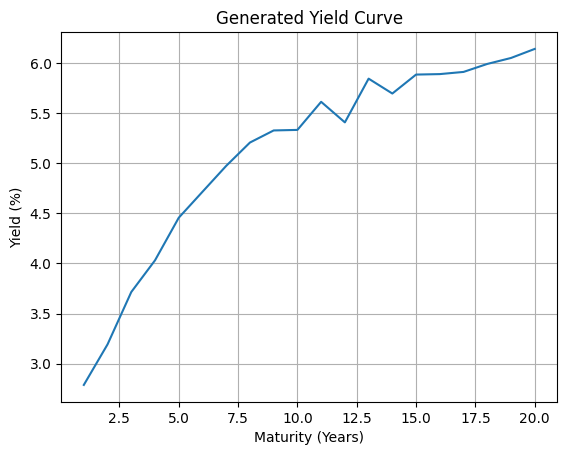

In [168]:
print("Generated yield curve:", new_curve)
import matplotlib.pyplot as plt

maturities = np.arange(1, 21)  # assuming '1' to '20' are years
plt.plot(maturities, new_curve[0])
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Generated Yield Curve")
plt.grid(True)
plt.show()

### Predict next days yield


  0%|          | 229/100000 [00:00<01:27, 1144.19it/s]

Epoch 0 | Loss: 1.0465


  0%|          | 461/100000 [00:00<01:27, 1139.88it/s]

Epoch 300 | Loss: 0.3052


  1%|          | 793/100000 [00:00<01:43, 959.38it/s] 

Epoch 600 | Loss: 0.1462


  1%|          | 1015/100000 [00:00<01:35, 1033.94it/s]

Epoch 900 | Loss: 0.1277


  1%|▏         | 1365/100000 [00:01<01:28, 1113.13it/s]

Epoch 1200 | Loss: 0.1063


  2%|▏         | 1705/100000 [00:01<01:27, 1118.28it/s]

Epoch 1500 | Loss: 0.1321


  2%|▏         | 1931/100000 [00:01<01:27, 1117.16it/s]

Epoch 1800 | Loss: 0.1481


  2%|▏         | 2277/100000 [00:02<01:26, 1123.65it/s]

Epoch 2100 | Loss: 0.1084


  3%|▎         | 2630/100000 [00:02<01:24, 1154.49it/s]

Epoch 2400 | Loss: 0.0819


  3%|▎         | 2872/100000 [00:02<01:21, 1185.12it/s]

Epoch 2700 | Loss: 0.0807


  3%|▎         | 3227/100000 [00:02<01:26, 1113.38it/s]

Epoch 3000 | Loss: 0.0844


  3%|▎         | 3458/100000 [00:03<01:25, 1127.72it/s]

Epoch 3300 | Loss: 0.0951


  4%|▍         | 3798/100000 [00:03<01:27, 1100.22it/s]

Epoch 3600 | Loss: 0.0796


  4%|▍         | 4041/100000 [00:03<01:22, 1162.90it/s]

Epoch 3900 | Loss: 0.0551


  4%|▍         | 4419/100000 [00:03<01:18, 1213.01it/s]

Epoch 4200 | Loss: 0.0618


  5%|▍         | 4664/100000 [00:04<01:19, 1194.24it/s]

Epoch 4500 | Loss: 0.0662


  5%|▌         | 5027/100000 [00:04<01:19, 1195.21it/s]

Epoch 4800 | Loss: 0.0404


  5%|▌         | 5269/100000 [00:04<01:19, 1193.38it/s]

Epoch 5100 | Loss: 0.0693


  6%|▌         | 5636/100000 [00:05<01:22, 1139.76it/s]

Epoch 5400 | Loss: 0.0488


  6%|▌         | 5878/100000 [00:05<01:20, 1172.91it/s]

Epoch 5700 | Loss: 0.0628


  6%|▌         | 6246/100000 [00:05<01:18, 1201.96it/s]

Epoch 6000 | Loss: 0.0663


  6%|▋         | 6492/100000 [00:05<01:17, 1212.76it/s]

Epoch 6300 | Loss: 0.0520


  7%|▋         | 6748/100000 [00:05<01:14, 1243.66it/s]

Epoch 6600 | Loss: 0.0778


  7%|▋         | 7132/100000 [00:06<01:14, 1253.06it/s]

Epoch 6900 | Loss: 0.0568


  7%|▋         | 7381/100000 [00:06<01:16, 1208.59it/s]

Epoch 7200 | Loss: 0.0488


  8%|▊         | 7621/100000 [00:06<01:22, 1125.78it/s]

Epoch 7500 | Loss: 0.0539


  8%|▊         | 7981/100000 [00:07<01:25, 1076.66it/s]

Epoch 7800 | Loss: 0.0522


  8%|▊         | 8327/100000 [00:07<01:22, 1116.89it/s]

Epoch 8100 | Loss: 0.0395


  9%|▊         | 8564/100000 [00:07<01:19, 1149.19it/s]

Epoch 8400 | Loss: 0.0388


  9%|▉         | 8931/100000 [00:07<01:16, 1192.38it/s]

Epoch 8700 | Loss: 0.0368


  9%|▉         | 9167/100000 [00:08<01:20, 1134.75it/s]

Epoch 9000 | Loss: 0.0596


 10%|▉         | 9521/100000 [00:08<01:18, 1150.36it/s]

Epoch 9300 | Loss: 0.0385


 10%|▉         | 9751/100000 [00:08<01:20, 1126.59it/s]

Epoch 9600 | Loss: 0.0509


 10%|█         | 10088/100000 [00:08<01:21, 1096.95it/s]

Epoch 9900 | Loss: 0.0261


 10%|█         | 10428/100000 [00:09<01:24, 1061.81it/s]

Epoch 10200 | Loss: 0.0464


 11%|█         | 10655/100000 [00:09<01:21, 1102.11it/s]

Epoch 10500 | Loss: 0.0452


 11%|█         | 11011/100000 [00:09<01:17, 1147.13it/s]

Epoch 10800 | Loss: 0.0345


 11%|█         | 11248/100000 [00:09<01:16, 1157.35it/s]

Epoch 11100 | Loss: 0.0317


 12%|█▏        | 11622/100000 [00:10<01:12, 1222.75it/s]

Epoch 11400 | Loss: 0.0325


 12%|█▏        | 11873/100000 [00:10<01:11, 1225.56it/s]

Epoch 11700 | Loss: 0.0421


 12%|█▏        | 12246/100000 [00:10<01:11, 1231.41it/s]

Epoch 12000 | Loss: 0.0387


 12%|█▏        | 12492/100000 [00:10<01:20, 1080.50it/s]

Epoch 12300 | Loss: 0.0415


 13%|█▎        | 12727/100000 [00:11<01:17, 1124.78it/s]

Epoch 12600 | Loss: 0.0263


 13%|█▎        | 13084/100000 [00:11<01:15, 1145.14it/s]

Epoch 12900 | Loss: 0.0179


 13%|█▎        | 13315/100000 [00:11<01:16, 1135.59it/s]

Epoch 13200 | Loss: 0.0440


 14%|█▎        | 13691/100000 [00:12<01:12, 1190.02it/s]

Epoch 13500 | Loss: 0.0383


 14%|█▍        | 13928/100000 [00:12<01:15, 1140.31it/s]

Epoch 13800 | Loss: 0.0398


 14%|█▍        | 14266/100000 [00:12<01:18, 1092.08it/s]

Epoch 14100 | Loss: 0.0316


 15%|█▍        | 14604/100000 [00:12<01:18, 1094.33it/s]

Epoch 14400 | Loss: 0.0218


 15%|█▍        | 14822/100000 [00:13<01:25, 1000.78it/s]

Epoch 14700 | Loss: 0.0151


 15%|█▌        | 15161/100000 [00:13<01:17, 1088.18it/s]

Epoch 15000 | Loss: 0.0203


 16%|█▌        | 15528/100000 [00:13<01:13, 1152.56it/s]

Epoch 15300 | Loss: 0.0300


 16%|█▌        | 15764/100000 [00:13<01:12, 1163.47it/s]

Epoch 15600 | Loss: 0.0218


 16%|█▌        | 16126/100000 [00:14<01:10, 1187.59it/s]

Epoch 15900 | Loss: 0.0347


 16%|█▋        | 16367/100000 [00:14<01:10, 1191.66it/s]

Epoch 16200 | Loss: 0.0369


 17%|█▋        | 16734/100000 [00:14<01:08, 1208.52it/s]

Epoch 16500 | Loss: 0.0289


 17%|█▋        | 16975/100000 [00:14<01:17, 1077.15it/s]

Epoch 16800 | Loss: 0.0279


 17%|█▋        | 17323/100000 [00:15<01:12, 1135.32it/s]

Epoch 17100 | Loss: 0.0178


 18%|█▊        | 17568/100000 [00:15<01:09, 1178.21it/s]

Epoch 17400 | Loss: 0.0215


 18%|█▊        | 17933/100000 [00:15<01:08, 1196.51it/s]

Epoch 17700 | Loss: 0.0345


 18%|█▊        | 18175/100000 [00:15<01:08, 1193.42it/s]

Epoch 18000 | Loss: 0.0328


 19%|█▊        | 18538/100000 [00:16<01:08, 1189.46it/s]

Epoch 18300 | Loss: 0.0330


 19%|█▉        | 18787/100000 [00:16<01:09, 1170.34it/s]

Epoch 18600 | Loss: 0.0413


 19%|█▉        | 19022/100000 [00:16<01:09, 1165.22it/s]

Epoch 18900 | Loss: 0.0348


 19%|█▉        | 19387/100000 [00:17<01:13, 1102.81it/s]

Epoch 19200 | Loss: 0.0275


 20%|█▉        | 19743/100000 [00:17<01:09, 1155.27it/s]

Epoch 19500 | Loss: 0.0174


 20%|█▉        | 19980/100000 [00:17<01:09, 1154.37it/s]

Epoch 19800 | Loss: 0.0262


 20%|██        | 20212/100000 [00:17<01:11, 1120.09it/s]

Epoch 20100 | Loss: 0.0237


 21%|██        | 20578/100000 [00:18<01:07, 1179.09it/s]

Epoch 20400 | Loss: 0.0342


 21%|██        | 20815/100000 [00:18<01:08, 1147.79it/s]

Epoch 20700 | Loss: 0.0151


 21%|██        | 21174/100000 [00:18<01:07, 1169.25it/s]

Epoch 21000 | Loss: 0.0214


 21%|██▏       | 21408/100000 [00:18<01:09, 1125.38it/s]

Epoch 21300 | Loss: 0.0209


 22%|██▏       | 21762/100000 [00:19<01:13, 1068.59it/s]

Epoch 21600 | Loss: 0.0133


 22%|██▏       | 22111/100000 [00:19<01:11, 1092.58it/s]

Epoch 21900 | Loss: 0.0155


 22%|██▏       | 22331/100000 [00:19<01:12, 1070.07it/s]

Epoch 22200 | Loss: 0.0430


 23%|██▎       | 22683/100000 [00:19<01:08, 1136.05it/s]

Epoch 22500 | Loss: 0.0246


 23%|██▎       | 23024/100000 [00:20<01:08, 1125.42it/s]

Epoch 22800 | Loss: 0.0163


 23%|██▎       | 23253/100000 [00:20<01:08, 1118.86it/s]

Epoch 23100 | Loss: 0.0194


 24%|██▎       | 23605/100000 [00:20<01:06, 1146.56it/s]

Epoch 23400 | Loss: 0.0186


 24%|██▍       | 23832/100000 [00:21<01:16, 990.61it/s] 

Epoch 23700 | Loss: 0.0196


 24%|██▍       | 24150/100000 [00:21<01:13, 1028.39it/s]

Epoch 24000 | Loss: 0.0387


 24%|██▍       | 24471/100000 [00:21<01:14, 1007.24it/s]

Epoch 24300 | Loss: 0.0184


 25%|██▍       | 24812/100000 [00:21<01:09, 1088.80it/s]

Epoch 24600 | Loss: 0.0179


 25%|██▌       | 25051/100000 [00:22<01:05, 1144.09it/s]

Epoch 24900 | Loss: 0.0180


 25%|██▌       | 25395/100000 [00:22<01:07, 1107.34it/s]

Epoch 25200 | Loss: 0.0129


 26%|██▌       | 25624/100000 [00:22<01:06, 1118.54it/s]

Epoch 25500 | Loss: 0.0189


 26%|██▌       | 25973/100000 [00:23<01:05, 1128.61it/s]

Epoch 25800 | Loss: 0.0095


 26%|██▋       | 26299/100000 [00:23<01:12, 1017.29it/s]

Epoch 26100 | Loss: 0.0123


 27%|██▋       | 26516/100000 [00:23<01:09, 1050.42it/s]

Epoch 26400 | Loss: 0.0273


 27%|██▋       | 26883/100000 [00:23<01:02, 1167.28it/s]

Epoch 26700 | Loss: 0.0182


 27%|██▋       | 27122/100000 [00:24<01:01, 1179.09it/s]

Epoch 27000 | Loss: 0.0189


 27%|██▋       | 27491/100000 [00:24<01:00, 1195.85it/s]

Epoch 27300 | Loss: 0.0110


 28%|██▊       | 27729/100000 [00:24<01:01, 1176.34it/s]

Epoch 27600 | Loss: 0.0186


 28%|██▊       | 28095/100000 [00:24<01:00, 1183.27it/s]

Epoch 27900 | Loss: 0.0173


 28%|██▊       | 28338/100000 [00:25<00:59, 1196.16it/s]

Epoch 28200 | Loss: 0.0236


 29%|██▊       | 28704/100000 [00:25<01:02, 1149.20it/s]

Epoch 28500 | Loss: 0.0224


 29%|██▉       | 28933/100000 [00:25<01:05, 1089.38it/s]

Epoch 28800 | Loss: 0.0224


 29%|██▉       | 29282/100000 [00:25<01:02, 1133.54it/s]

Epoch 29100 | Loss: 0.0272


 30%|██▉       | 29517/100000 [00:26<01:02, 1135.73it/s]

Epoch 29400 | Loss: 0.0166


 30%|██▉       | 29858/100000 [00:26<01:04, 1086.35it/s]

Epoch 29700 | Loss: 0.0163


 30%|███       | 30166/100000 [00:26<01:12, 967.09it/s] 

Epoch 30000 | Loss: 0.0204


 30%|███       | 30488/100000 [00:27<01:12, 960.47it/s] 

Epoch 30300 | Loss: 0.0211


 31%|███       | 30716/100000 [00:27<01:06, 1046.09it/s]

Epoch 30600 | Loss: 0.0199


 31%|███       | 31088/100000 [00:27<00:58, 1172.75it/s]

Epoch 30900 | Loss: 0.0253


 31%|███▏      | 31323/100000 [00:27<00:59, 1146.52it/s]

Epoch 31200 | Loss: 0.0251


 32%|███▏      | 31688/100000 [00:28<00:58, 1172.55it/s]

Epoch 31500 | Loss: 0.0340


 32%|███▏      | 31925/100000 [00:28<00:58, 1169.75it/s]

Epoch 31800 | Loss: 0.0084


 32%|███▏      | 32293/100000 [00:28<00:56, 1205.94it/s]

Epoch 32100 | Loss: 0.0273


 33%|███▎      | 32532/100000 [00:28<00:57, 1167.92it/s]

Epoch 32400 | Loss: 0.0123


 33%|███▎      | 32881/100000 [00:29<01:04, 1046.53it/s]

Epoch 32700 | Loss: 0.0169


 33%|███▎      | 33222/100000 [00:29<01:00, 1106.92it/s]

Epoch 33000 | Loss: 0.0162


 33%|███▎      | 33446/100000 [00:29<01:01, 1085.11it/s]

Epoch 33300 | Loss: 0.0160


 34%|███▍      | 33806/100000 [00:30<00:56, 1163.99it/s]

Epoch 33600 | Loss: 0.0187


 34%|███▍      | 34043/100000 [00:30<00:56, 1166.22it/s]

Epoch 33900 | Loss: 0.0126


 34%|███▍      | 34403/100000 [00:30<00:56, 1158.44it/s]

Epoch 34200 | Loss: 0.0154


 35%|███▍      | 34641/100000 [00:30<00:56, 1163.63it/s]

Epoch 34500 | Loss: 0.0203


 35%|███▌      | 35015/100000 [00:31<00:59, 1100.61it/s]

Epoch 34800 | Loss: 0.0094


 35%|███▌      | 35250/100000 [00:31<00:57, 1128.59it/s]

Epoch 35100 | Loss: 0.0133


 36%|███▌      | 35629/100000 [00:31<00:52, 1221.20it/s]

Epoch 35400 | Loss: 0.0192


 36%|███▌      | 35874/100000 [00:31<00:53, 1207.92it/s]

Epoch 35700 | Loss: 0.0184


 36%|███▌      | 36117/100000 [00:32<00:53, 1183.18it/s]

Epoch 36000 | Loss: 0.0109


 36%|███▋      | 36484/100000 [00:32<00:53, 1193.43it/s]

Epoch 36300 | Loss: 0.0135


 37%|███▋      | 36728/100000 [00:32<00:53, 1180.15it/s]

Epoch 36600 | Loss: 0.0155


 37%|███▋      | 37099/100000 [00:32<00:53, 1170.24it/s]

Epoch 36900 | Loss: 0.0154


 37%|███▋      | 37337/100000 [00:33<00:57, 1088.11it/s]

Epoch 37200 | Loss: 0.0147


 38%|███▊      | 37685/100000 [00:33<00:55, 1114.38it/s]

Epoch 37500 | Loss: 0.0164


 38%|███▊      | 37927/100000 [00:33<00:53, 1163.21it/s]

Epoch 37800 | Loss: 0.0111


 38%|███▊      | 38287/100000 [00:33<00:53, 1161.29it/s]

Epoch 38100 | Loss: 0.0114


 39%|███▊      | 38520/100000 [00:34<00:53, 1154.18it/s]

Epoch 38400 | Loss: 0.0321


 39%|███▉      | 38882/100000 [00:34<00:52, 1157.32it/s]

Epoch 38700 | Loss: 0.0259


 39%|███▉      | 39116/100000 [00:34<00:52, 1149.03it/s]

Epoch 39000 | Loss: 0.0107


 39%|███▉      | 39469/100000 [00:35<00:56, 1063.33it/s]

Epoch 39300 | Loss: 0.0238


 40%|███▉      | 39816/100000 [00:35<00:53, 1123.82it/s]

Epoch 39600 | Loss: 0.0146


 40%|████      | 40055/100000 [00:35<00:51, 1161.10it/s]

Epoch 39900 | Loss: 0.0096


 40%|████      | 40428/100000 [00:35<00:49, 1206.87it/s]

Epoch 40200 | Loss: 0.0111


 41%|████      | 40669/100000 [00:36<00:50, 1170.84it/s]

Epoch 40500 | Loss: 0.0201


 41%|████      | 41021/100000 [00:36<00:51, 1155.66it/s]

Epoch 40800 | Loss: 0.0106


 41%|████▏     | 41256/100000 [00:36<00:50, 1164.53it/s]

Epoch 41100 | Loss: 0.0087


 41%|████▏     | 41495/100000 [00:36<00:56, 1037.19it/s]

Epoch 41400 | Loss: 0.0139


 42%|████▏     | 41838/100000 [00:37<00:53, 1094.46it/s]

Epoch 41700 | Loss: 0.0113


 42%|████▏     | 42203/100000 [00:37<00:50, 1145.48it/s]

Epoch 42000 | Loss: 0.0249


 42%|████▏     | 42443/100000 [00:37<00:49, 1164.12it/s]

Epoch 42300 | Loss: 0.0128


 43%|████▎     | 42802/100000 [00:37<00:48, 1171.77it/s]

Epoch 42600 | Loss: 0.0078


 43%|████▎     | 43037/100000 [00:38<00:49, 1151.27it/s]

Epoch 42900 | Loss: 0.0139


 43%|████▎     | 43414/100000 [00:38<00:46, 1205.38it/s]

Epoch 43200 | Loss: 0.0107


 44%|████▎     | 43655/100000 [00:38<00:52, 1072.43it/s]

Epoch 43500 | Loss: 0.0101


 44%|████▍     | 44010/100000 [00:38<00:49, 1142.41it/s]

Epoch 43800 | Loss: 0.0116


 44%|████▍     | 44249/100000 [00:39<00:48, 1139.57it/s]

Epoch 44100 | Loss: 0.0087


 45%|████▍     | 44617/100000 [00:39<00:46, 1194.46it/s]

Epoch 44400 | Loss: 0.0232


 45%|████▍     | 44856/100000 [00:39<00:47, 1166.10it/s]

Epoch 44700 | Loss: 0.0101


 45%|████▌     | 45219/100000 [00:40<00:46, 1181.87it/s]

Epoch 45000 | Loss: 0.0115


 45%|████▌     | 45457/100000 [00:40<00:46, 1175.68it/s]

Epoch 45300 | Loss: 0.0109


 46%|████▌     | 45819/100000 [00:40<00:48, 1113.47it/s]

Epoch 45600 | Loss: 0.0152


 46%|████▌     | 46050/100000 [00:40<00:47, 1125.13it/s]

Epoch 45900 | Loss: 0.0064


 46%|████▋     | 46415/100000 [00:41<00:45, 1171.75it/s]

Epoch 46200 | Loss: 0.0100


 47%|████▋     | 46649/100000 [00:41<00:46, 1145.22it/s]

Epoch 46500 | Loss: 0.0171


 47%|████▋     | 47004/100000 [00:41<00:45, 1160.64it/s]

Epoch 46800 | Loss: 0.0130


 47%|████▋     | 47238/100000 [00:41<00:45, 1149.32it/s]

Epoch 47100 | Loss: 0.0086


 48%|████▊     | 47591/100000 [00:42<00:45, 1160.57it/s]

Epoch 47400 | Loss: 0.0219


 48%|████▊     | 47824/100000 [00:42<00:50, 1033.86it/s]

Epoch 47700 | Loss: 0.0197


 48%|████▊     | 48188/100000 [00:42<00:44, 1152.53it/s]

Epoch 48000 | Loss: 0.0176


 48%|████▊     | 48421/100000 [00:42<00:45, 1127.07it/s]

Epoch 48300 | Loss: 0.0180


 49%|████▉     | 48792/100000 [00:43<00:43, 1190.19it/s]

Epoch 48600 | Loss: 0.0091


 49%|████▉     | 49030/100000 [00:43<00:44, 1139.82it/s]

Epoch 48900 | Loss: 0.0184


 49%|████▉     | 49396/100000 [00:43<00:42, 1187.42it/s]

Epoch 49200 | Loss: 0.0148


 50%|████▉     | 49633/100000 [00:43<00:42, 1172.68it/s]

Epoch 49500 | Loss: 0.0074


 50%|█████     | 50012/100000 [00:44<00:44, 1119.56it/s]

Epoch 49800 | Loss: 0.0174


 50%|█████     | 50242/100000 [00:44<00:44, 1121.85it/s]

Epoch 50100 | Loss: 0.0175


 51%|█████     | 50612/100000 [00:44<00:42, 1174.16it/s]

Epoch 50400 | Loss: 0.0126


 51%|█████     | 50857/100000 [00:44<00:41, 1178.93it/s]

Epoch 50700 | Loss: 0.0140


 51%|█████     | 51224/100000 [00:45<00:41, 1176.87it/s]

Epoch 51000 | Loss: 0.0084


 51%|█████▏    | 51463/100000 [00:45<00:41, 1172.94it/s]

Epoch 51300 | Loss: 0.0120


 52%|█████▏    | 51815/100000 [00:45<00:41, 1165.21it/s]

Epoch 51600 | Loss: 0.0132


 52%|█████▏    | 52049/100000 [00:46<00:46, 1037.35it/s]

Epoch 51900 | Loss: 0.0132


 52%|█████▏    | 52405/100000 [00:46<00:41, 1135.95it/s]

Epoch 52200 | Loss: 0.0095


 53%|█████▎    | 52639/100000 [00:46<00:41, 1136.41it/s]

Epoch 52500 | Loss: 0.0115


 53%|█████▎    | 53023/100000 [00:46<00:38, 1213.98it/s]

Epoch 52800 | Loss: 0.0113


 53%|█████▎    | 53265/100000 [00:47<00:39, 1188.95it/s]

Epoch 53100 | Loss: 0.0080


 54%|█████▎    | 53629/100000 [00:47<00:39, 1184.10it/s]

Epoch 53400 | Loss: 0.0103


 54%|█████▍    | 53868/100000 [00:47<00:39, 1173.26it/s]

Epoch 53700 | Loss: 0.0170


 54%|█████▍    | 54113/100000 [00:47<00:42, 1072.40it/s]

Epoch 54000 | Loss: 0.0109


 54%|█████▍    | 54470/100000 [00:48<00:40, 1127.87it/s]

Epoch 54300 | Loss: 0.0284


 55%|█████▍    | 54838/100000 [00:48<00:37, 1191.36it/s]

Epoch 54600 | Loss: 0.0150


 55%|█████▌    | 55077/100000 [00:48<00:38, 1178.62it/s]

Epoch 54900 | Loss: 0.0096


 55%|█████▌    | 55456/100000 [00:48<00:36, 1233.13it/s]

Epoch 55200 | Loss: 0.0133


 56%|█████▌    | 55700/100000 [00:49<00:37, 1167.42it/s]

Epoch 55500 | Loss: 0.0163


 56%|█████▌    | 55936/100000 [00:49<00:38, 1158.25it/s]

Epoch 55800 | Loss: 0.0208


 56%|█████▋    | 56287/100000 [00:49<00:41, 1064.31it/s]

Epoch 56100 | Loss: 0.0110


 57%|█████▋    | 56504/100000 [00:49<00:42, 1027.43it/s]

Epoch 56400 | Loss: 0.0097


 57%|█████▋    | 56839/100000 [00:50<00:39, 1085.40it/s]

Epoch 56700 | Loss: 0.0116


 57%|█████▋    | 57173/100000 [00:50<00:39, 1092.54it/s]

Epoch 57000 | Loss: 0.0081


 58%|█████▊    | 57514/100000 [00:50<00:37, 1121.74it/s]

Epoch 57300 | Loss: 0.0083


 58%|█████▊    | 57739/100000 [00:51<00:38, 1095.45it/s]

Epoch 57600 | Loss: 0.0102


 58%|█████▊    | 58073/100000 [00:51<00:39, 1071.32it/s]

Epoch 57900 | Loss: 0.0100


 58%|█████▊    | 58410/100000 [00:51<00:41, 1011.86it/s]

Epoch 58200 | Loss: 0.0112


 59%|█████▊    | 58616/100000 [00:51<00:41, 991.68it/s] 

Epoch 58500 | Loss: 0.0172


 59%|█████▉    | 58936/100000 [00:52<00:39, 1044.11it/s]

Epoch 58800 | Loss: 0.0196


 59%|█████▉    | 59288/100000 [00:52<00:36, 1127.02it/s]

Epoch 59100 | Loss: 0.0081


 60%|█████▉    | 59517/100000 [00:52<00:37, 1082.57it/s]

Epoch 59400 | Loss: 0.0093


 60%|█████▉    | 59871/100000 [00:53<00:35, 1124.02it/s]

Epoch 59700 | Loss: 0.0090


 60%|██████    | 60219/100000 [00:53<00:34, 1139.64it/s]

Epoch 60000 | Loss: 0.0084


 60%|██████    | 60453/100000 [00:53<00:37, 1058.89it/s]

Epoch 60300 | Loss: 0.0231


 61%|██████    | 60809/100000 [00:53<00:34, 1138.75it/s]

Epoch 60600 | Loss: 0.0078


 61%|██████    | 61041/100000 [00:54<00:34, 1126.99it/s]

Epoch 60900 | Loss: 0.0179


 61%|██████▏   | 61392/100000 [00:54<00:34, 1128.60it/s]

Epoch 61200 | Loss: 0.0147


 62%|██████▏   | 61621/100000 [00:54<00:34, 1120.42it/s]

Epoch 61500 | Loss: 0.0154


 62%|██████▏   | 61984/100000 [00:54<00:33, 1151.39it/s]

Epoch 61800 | Loss: 0.0071


 62%|██████▏   | 62215/100000 [00:55<00:34, 1108.25it/s]

Epoch 62100 | Loss: 0.0215


 63%|██████▎   | 62556/100000 [00:55<00:35, 1059.79it/s]

Epoch 62400 | Loss: 0.0133


 63%|██████▎   | 62906/100000 [00:55<00:32, 1132.97it/s]

Epoch 62700 | Loss: 0.0125


 63%|██████▎   | 63135/100000 [00:55<00:32, 1124.21it/s]

Epoch 63000 | Loss: 0.0095


 63%|██████▎   | 63480/100000 [00:56<00:33, 1105.61it/s]

Epoch 63300 | Loss: 0.0101


 64%|██████▍   | 63816/100000 [00:56<00:32, 1111.00it/s]

Epoch 63600 | Loss: 0.0072


 64%|██████▍   | 64052/100000 [00:56<00:31, 1148.66it/s]

Epoch 63900 | Loss: 0.0083


 64%|██████▍   | 64406/100000 [00:57<00:32, 1094.72it/s]

Epoch 64200 | Loss: 0.0114


 65%|██████▍   | 64630/100000 [00:57<00:32, 1104.03it/s]

Epoch 64500 | Loss: 0.0104


 65%|██████▍   | 64976/100000 [00:57<00:30, 1135.84it/s]

Epoch 64800 | Loss: 0.0115


 65%|██████▌   | 65332/100000 [00:57<00:30, 1147.08it/s]

Epoch 65100 | Loss: 0.0170


 66%|██████▌   | 65562/100000 [00:58<00:30, 1112.48it/s]

Epoch 65400 | Loss: 0.0079


 66%|██████▌   | 65916/100000 [00:58<00:29, 1152.42it/s]

Epoch 65700 | Loss: 0.0084


 66%|██████▌   | 66154/100000 [00:58<00:29, 1144.24it/s]

Epoch 66000 | Loss: 0.0091


 66%|██████▋   | 66499/100000 [00:59<00:31, 1050.58it/s]

Epoch 66300 | Loss: 0.0071


 67%|██████▋   | 66718/100000 [00:59<00:31, 1070.23it/s]

Epoch 66600 | Loss: 0.0113


 67%|██████▋   | 67073/100000 [00:59<00:29, 1106.33it/s]

Epoch 66900 | Loss: 0.0089


 67%|██████▋   | 67415/100000 [00:59<00:29, 1106.76it/s]

Epoch 67200 | Loss: 0.0114


 68%|██████▊   | 67647/100000 [01:00<00:28, 1134.91it/s]

Epoch 67500 | Loss: 0.0225


 68%|██████▊   | 67995/100000 [01:00<00:29, 1092.71it/s]

Epoch 67800 | Loss: 0.0104


 68%|██████▊   | 68211/100000 [01:00<00:30, 1049.97it/s]

Epoch 68100 | Loss: 0.0264


 69%|██████▊   | 68551/100000 [01:00<00:31, 995.97it/s] 

Epoch 68400 | Loss: 0.0063


 69%|██████▉   | 68871/100000 [01:01<00:30, 1035.95it/s]

Epoch 68700 | Loss: 0.0066


 69%|██████▉   | 69216/100000 [01:01<00:27, 1119.85it/s]

Epoch 69000 | Loss: 0.0107


 69%|██████▉   | 69440/100000 [01:01<00:27, 1095.68it/s]

Epoch 69300 | Loss: 0.0061


 70%|██████▉   | 69789/100000 [01:02<00:26, 1138.63it/s]

Epoch 69600 | Loss: 0.0125


 70%|███████   | 70017/100000 [01:02<00:27, 1082.89it/s]

Epoch 69900 | Loss: 0.0145


 70%|███████   | 70380/100000 [01:02<00:25, 1160.60it/s]

Epoch 70200 | Loss: 0.0131


 71%|███████   | 70742/100000 [01:02<00:26, 1119.33it/s]

Epoch 70500 | Loss: 0.0139


 71%|███████   | 70970/100000 [01:03<00:26, 1091.25it/s]

Epoch 70800 | Loss: 0.0058


 71%|███████▏  | 71305/100000 [01:03<00:26, 1083.95it/s]

Epoch 71100 | Loss: 0.0148


 72%|███████▏  | 71523/100000 [01:03<00:26, 1058.09it/s]

Epoch 71400 | Loss: 0.0057


 72%|███████▏  | 71887/100000 [01:03<00:24, 1149.79it/s]

Epoch 71700 | Loss: 0.0099


 72%|███████▏  | 72115/100000 [01:04<00:25, 1089.48it/s]

Epoch 72000 | Loss: 0.0101


 72%|███████▏  | 72446/100000 [01:04<00:25, 1080.95it/s]

Epoch 72300 | Loss: 0.0160


 73%|███████▎  | 72764/100000 [01:04<00:27, 988.17it/s] 

Epoch 72600 | Loss: 0.0128


 73%|███████▎  | 73098/100000 [01:05<00:25, 1039.95it/s]

Epoch 72900 | Loss: 0.0114


 73%|███████▎  | 73319/100000 [01:05<00:24, 1070.65it/s]

Epoch 73200 | Loss: 0.0087


 74%|███████▎  | 73685/100000 [01:05<00:23, 1134.58it/s]

Epoch 73500 | Loss: 0.0115


 74%|███████▍  | 74033/100000 [01:06<00:22, 1145.73it/s]

Epoch 73800 | Loss: 0.0161


 74%|███████▍  | 74260/100000 [01:06<00:23, 1087.39it/s]

Epoch 74100 | Loss: 0.0111


 74%|███████▍  | 74478/100000 [01:06<00:26, 951.44it/s] 

Epoch 74400 | Loss: 0.0130


 75%|███████▍  | 74830/100000 [01:06<00:23, 1056.10it/s]

Epoch 74700 | Loss: 0.0078


 75%|███████▌  | 75191/100000 [01:07<00:22, 1121.68it/s]

Epoch 75000 | Loss: 0.0071


 75%|███████▌  | 75427/100000 [01:07<00:21, 1148.82it/s]

Epoch 75300 | Loss: 0.0075


 76%|███████▌  | 75805/100000 [01:07<00:19, 1222.32it/s]

Epoch 75600 | Loss: 0.0146


 76%|███████▌  | 76049/100000 [01:07<00:20, 1192.38it/s]

Epoch 75900 | Loss: 0.0167


 76%|███████▋  | 76424/100000 [01:08<00:19, 1234.72it/s]

Epoch 76200 | Loss: 0.0056


 77%|███████▋  | 76669/100000 [01:08<00:19, 1188.67it/s]

Epoch 76500 | Loss: 0.0105


 77%|███████▋  | 77022/100000 [01:08<00:20, 1123.74it/s]

Epoch 76800 | Loss: 0.0074


 77%|███████▋  | 77252/100000 [01:08<00:22, 1006.42it/s]

Epoch 77100 | Loss: 0.0078


 78%|███████▊  | 77608/100000 [01:09<00:20, 1115.40it/s]

Epoch 77400 | Loss: 0.0044


 78%|███████▊  | 77858/100000 [01:09<00:18, 1182.56it/s]

Epoch 77700 | Loss: 0.0232


 78%|███████▊  | 78224/100000 [01:09<00:17, 1210.47it/s]

Epoch 78000 | Loss: 0.0097


 78%|███████▊  | 78470/100000 [01:09<00:18, 1194.41it/s]

Epoch 78300 | Loss: 0.0150


 79%|███████▉  | 78863/100000 [01:10<00:16, 1269.84it/s]

Epoch 78600 | Loss: 0.0093


 79%|███████▉  | 79117/100000 [01:10<00:16, 1244.71it/s]

Epoch 78900 | Loss: 0.0061


 79%|███████▉  | 79367/100000 [01:10<00:16, 1241.25it/s]

Epoch 79200 | Loss: 0.0221


 80%|███████▉  | 79616/100000 [01:10<00:16, 1225.88it/s]

Epoch 79500 | Loss: 0.0054


 80%|███████▉  | 79978/100000 [01:11<00:16, 1182.16it/s]

Epoch 79800 | Loss: 0.0104


 80%|████████  | 80218/100000 [01:11<00:18, 1070.27it/s]

Epoch 80100 | Loss: 0.0090


 81%|████████  | 80586/100000 [01:11<00:17, 1120.49it/s]

Epoch 80400 | Loss: 0.0061


 81%|████████  | 80936/100000 [01:11<00:16, 1149.95it/s]

Epoch 80700 | Loss: 0.0086


 81%|████████  | 81186/100000 [01:12<00:15, 1205.71it/s]

Epoch 81000 | Loss: 0.0070


 81%|████████▏ | 81428/100000 [01:12<00:15, 1201.26it/s]

Epoch 81300 | Loss: 0.0065


 82%|████████▏ | 81793/100000 [01:12<00:15, 1175.88it/s]

Epoch 81600 | Loss: 0.0057


 82%|████████▏ | 82038/100000 [01:12<00:14, 1198.03it/s]

Epoch 81900 | Loss: 0.0109


 82%|████████▏ | 82405/100000 [01:13<00:14, 1212.28it/s]

Epoch 82200 | Loss: 0.0127


 83%|████████▎ | 82648/100000 [01:13<00:14, 1175.02it/s]

Epoch 82500 | Loss: 0.0063


 83%|████████▎ | 83005/100000 [01:13<00:14, 1165.17it/s]

Epoch 82800 | Loss: 0.0086


 83%|████████▎ | 83238/100000 [01:13<00:15, 1078.20it/s]

Epoch 83100 | Loss: 0.0108


 84%|████████▎ | 83616/100000 [01:14<00:13, 1194.40it/s]

Epoch 83400 | Loss: 0.0107


 84%|████████▍ | 83871/100000 [01:14<00:13, 1231.98it/s]

Epoch 83700 | Loss: 0.0066


 84%|████████▍ | 84119/100000 [01:14<00:12, 1228.51it/s]

Epoch 84000 | Loss: 0.0110


 84%|████████▍ | 84483/100000 [01:14<00:13, 1178.65it/s]

Epoch 84300 | Loss: 0.0080


 85%|████████▍ | 84732/100000 [01:15<00:12, 1207.73it/s]

Epoch 84600 | Loss: 0.0087


 85%|████████▌ | 85112/100000 [01:15<00:11, 1244.83it/s]

Epoch 84900 | Loss: 0.0188


 85%|████████▌ | 85359/100000 [01:15<00:12, 1208.18it/s]

Epoch 85200 | Loss: 0.0096


 86%|████████▌ | 85729/100000 [01:16<00:11, 1217.95it/s]

Epoch 85500 | Loss: 0.0172


 86%|████████▌ | 85981/100000 [01:16<00:11, 1231.65it/s]

Epoch 85800 | Loss: 0.0089


 86%|████████▌ | 86229/100000 [01:16<00:12, 1128.58it/s]

Epoch 86100 | Loss: 0.0060


 87%|████████▋ | 86612/100000 [01:16<00:10, 1226.64it/s]

Epoch 86400 | Loss: 0.0075


 87%|████████▋ | 86864/100000 [01:16<00:10, 1226.34it/s]

Epoch 86700 | Loss: 0.0076


 87%|████████▋ | 87238/100000 [01:17<00:10, 1218.45it/s]

Epoch 87000 | Loss: 0.0098


 87%|████████▋ | 87486/100000 [01:17<00:10, 1218.30it/s]

Epoch 87300 | Loss: 0.0131


 88%|████████▊ | 87729/100000 [01:17<00:10, 1203.22it/s]

Epoch 87600 | Loss: 0.0112


 88%|████████▊ | 88109/100000 [01:17<00:09, 1224.32it/s]

Epoch 87900 | Loss: 0.0092


 88%|████████▊ | 88355/100000 [01:18<00:09, 1205.95it/s]

Epoch 88200 | Loss: 0.0102


 89%|████████▊ | 88735/100000 [01:18<00:09, 1247.07it/s]

Epoch 88500 | Loss: 0.0238


 89%|████████▉ | 88984/100000 [01:18<00:09, 1198.32it/s]

Epoch 88800 | Loss: 0.0202


 89%|████████▉ | 89225/100000 [01:18<00:09, 1110.78it/s]

Epoch 89100 | Loss: 0.0079


 90%|████████▉ | 89600/100000 [01:19<00:08, 1185.65it/s]

Epoch 89400 | Loss: 0.0057


 90%|████████▉ | 89853/100000 [01:19<00:08, 1225.45it/s]

Epoch 89700 | Loss: 0.0104


 90%|█████████ | 90227/100000 [01:19<00:08, 1219.07it/s]

Epoch 90000 | Loss: 0.0128


 90%|█████████ | 90478/100000 [01:19<00:07, 1226.74it/s]

Epoch 90300 | Loss: 0.0165


 91%|█████████ | 90724/100000 [01:20<00:07, 1219.29it/s]

Epoch 90600 | Loss: 0.0136


 91%|█████████ | 91106/100000 [01:20<00:07, 1226.05it/s]

Epoch 90900 | Loss: 0.0136


 91%|█████████▏| 91359/100000 [01:20<00:07, 1192.51it/s]

Epoch 91200 | Loss: 0.0088


 92%|█████████▏| 91724/100000 [01:20<00:06, 1197.64it/s]

Epoch 91500 | Loss: 0.0073


 92%|█████████▏| 91976/100000 [01:21<00:06, 1224.71it/s]

Epoch 91800 | Loss: 0.0075


 92%|█████████▏| 92353/100000 [01:21<00:06, 1186.12it/s]

Epoch 92100 | Loss: 0.0175


 93%|█████████▎| 92596/100000 [01:21<00:06, 1190.59it/s]

Epoch 92400 | Loss: 0.0055


 93%|█████████▎| 92839/100000 [01:21<00:05, 1195.55it/s]

Epoch 92700 | Loss: 0.0076


 93%|█████████▎| 93224/100000 [01:22<00:05, 1213.96it/s]

Epoch 93000 | Loss: 0.0084


 93%|█████████▎| 93476/100000 [01:22<00:05, 1233.98it/s]

Epoch 93300 | Loss: 0.0111


 94%|█████████▎| 93722/100000 [01:22<00:05, 1216.39it/s]

Epoch 93600 | Loss: 0.0085


 94%|█████████▍| 94085/100000 [01:22<00:05, 1182.78it/s]

Epoch 93900 | Loss: 0.0098


 94%|█████████▍| 94325/100000 [01:23<00:04, 1187.37it/s]

Epoch 94200 | Loss: 0.0121


 95%|█████████▍| 94698/100000 [01:23<00:04, 1220.48it/s]

Epoch 94500 | Loss: 0.0187


 95%|█████████▍| 94946/100000 [01:23<00:04, 1227.55it/s]

Epoch 94800 | Loss: 0.0144


 95%|█████████▌| 95315/100000 [01:24<00:04, 1161.72it/s]

Epoch 95100 | Loss: 0.0100


 96%|█████████▌| 95550/100000 [01:24<00:03, 1157.89it/s]

Epoch 95400 | Loss: 0.0152


 96%|█████████▌| 95914/100000 [01:24<00:03, 1197.14it/s]

Epoch 95700 | Loss: 0.0098


 96%|█████████▌| 96167/100000 [01:24<00:03, 1230.69it/s]

Epoch 96000 | Loss: 0.0068


 97%|█████████▋| 96544/100000 [01:25<00:02, 1229.92it/s]

Epoch 96300 | Loss: 0.0081


 97%|█████████▋| 96792/100000 [01:25<00:02, 1233.03it/s]

Epoch 96600 | Loss: 0.0102


 97%|█████████▋| 97039/100000 [01:25<00:02, 1228.43it/s]

Epoch 96900 | Loss: 0.0063


 97%|█████████▋| 97406/100000 [01:25<00:02, 1185.88it/s]

Epoch 97200 | Loss: 0.0091


 98%|█████████▊| 97647/100000 [01:25<00:01, 1186.56it/s]

Epoch 97500 | Loss: 0.0120


 98%|█████████▊| 98029/100000 [01:26<00:01, 1136.96it/s]

Epoch 97800 | Loss: 0.0206


 98%|█████████▊| 98279/100000 [01:26<00:01, 1194.10it/s]

Epoch 98100 | Loss: 0.0082


 99%|█████████▊| 98527/100000 [01:26<00:01, 1215.99it/s]

Epoch 98400 | Loss: 0.0125


 99%|█████████▉| 98897/100000 [01:27<00:00, 1192.30it/s]

Epoch 98700 | Loss: 0.0097


 99%|█████████▉| 99137/100000 [01:27<00:00, 1177.70it/s]

Epoch 99000 | Loss: 0.0046


100%|█████████▉| 99510/100000 [01:27<00:00, 1216.04it/s]

Epoch 99300 | Loss: 0.0119


100%|█████████▉| 99752/100000 [01:27<00:00, 1180.53it/s]

Epoch 99600 | Loss: 0.0064


100%|██████████| 100000/100000 [01:27<00:00, 1137.19it/s]


Epoch 99900 | Loss: 0.0085


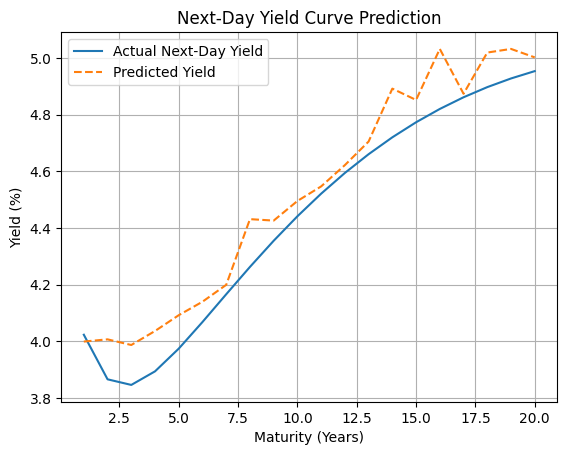

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# === Load & preprocess data ===
yield_data = plot_data.loc[:, '1':'20'].values.astype(np.float32)

# Standardize per maturity
scaler = StandardScaler()
yield_data = scaler.fit_transform(yield_data)

# Create (x_prev, x_next) pairs
X_prev = torch.tensor(yield_data[:-1], dtype=torch.float32)
X_next = torch.tensor(yield_data[1:], dtype=torch.float32)

# === Diffusion Parameters ===
T = 1000  # fewer steps to make it easier to train
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)
alpha_bars = torch.clamp(alpha_bars, min=1e-5)

# === Conditional Denoising Model ===
class CondDenoiseMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim * 2 + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, dim),
        )

    def forward(self, x, t, cond):
        t = t.unsqueeze(1).float() / T
        x_in = torch.cat([x, t, cond], dim=1)
        return self.model(x_in)

model = CondDenoiseMLP(dim=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Noise function ===
def q_sample(x0, t, noise):
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t])[:, None]
    sqrt_one_minus = torch.sqrt(1 - alpha_bars[t])[:, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

# === Training loop ===
epochs = 100000
batch_size = 128

for epoch in tqdm(range(epochs)):
    idx = torch.randint(0, X_prev.shape[0], (batch_size,))
    x_prev = X_prev[idx]
    x_true = X_next[idx]

    t = torch.randint(0, T, (batch_size,))
    noise = torch.randn_like(x_true)
    xt = q_sample(x_true, t, noise)

    pred = model(xt, t, cond=x_prev)
    loss = F.mse_loss(pred, noise)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

# === Sampling: Predict next day's curve given today's ===
@torch.no_grad()
def predict_next_curve(model, x_prev, T=T):
    x = torch.randn(1, 20)
    x_prev = x_prev.unsqueeze(0)

    for t in reversed(range(T)):
        t_tensor = torch.full((1,), t, dtype=torch.long)
        pred_noise = model(x, t_tensor, cond=x_prev)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]

        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(torch.clamp(1 - alpha_bar_t, min=1e-8))
        sqrt_beta_t = torch.sqrt(beta_t)

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / sqrt_alpha_t) * (x - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise) + sqrt_beta_t * noise

    return x.squeeze(0)

# === Predict one example ===
today = X_prev[-1]  # Most recent curve
predicted = predict_next_curve(model, today)
predicted_yield = scaler.inverse_transform(predicted.numpy().reshape(1, -1))
true_yield = scaler.inverse_transform(X_next[-1].numpy().reshape(1, -1))

# === Plot ===
maturities = np.arange(1, 21)
plt.plot(maturities, true_yield[0], label='Actual Next-Day Yield')
plt.plot(maturities, predicted_yield[0], label='Predicted Yield', linestyle='--')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Next-Day Yield Curve Prediction")
plt.legend()
plt.grid(True)
plt.show()

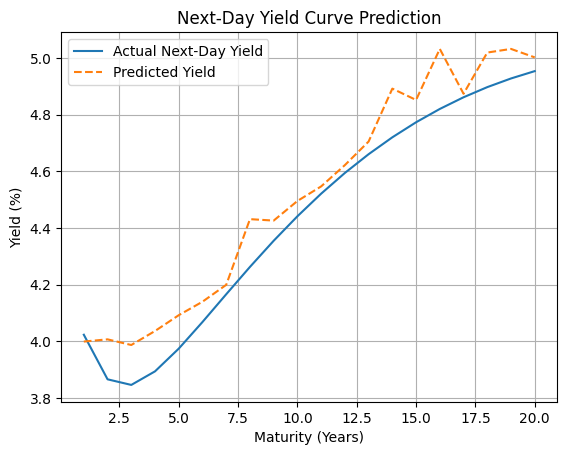

In [85]:
maturities = np.arange(1, 21)
plt.plot(maturities, true_yield[0], label='Actual Next-Day Yield')
plt.plot(maturities, predicted_yield[0], label='Predicted Yield', linestyle='--')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Next-Day Yield Curve Prediction")
plt.legend()
plt.grid(True)
plt.show()

# GRU 

Packages

In [174]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

Data

In [144]:
yield_data = data2.loc[:, '1':'20'].values
yield_data = pd.DataFrame(yield_data, columns=plot_data.columns[1:])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(yield_data.values)


In [145]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0]) 
        y.append(data[i + time_step, 0]) 
    return np.array(X), np.array(y)

time_step = 5 
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print(X.shape) 
print(y.shape) 

(10061, 5, 1)
(10061,)


Building GRU model

In [146]:
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(GRU(units=50))
model.add(Dense(units=1)) 
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU model

In [147]:
model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0240
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4449e-05
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4428e-05
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1753e-05
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7550e-05
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7615e-05
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8271e-05
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4933e-05
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2394e-05
Epoch 10/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7992e-05


Predicting 

In [148]:
input_sequence = scaled_data[-time_step:].reshape(20, time_step, 1)
predicted_values = model.predict(input_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


In [149]:
predicted_values = pd.DataFrame(predicted_values)
predicted_values.head(21)

,0
0,0.329467
1,0.330327
2,0.343457
3,0.343630
4,0.322800
5,0.325593
6,0.339484
7,0.339885
8,0.319458
9,0.321097


Inverse predictions

In [156]:
import numpy as np

# Convert to NumPy and reshape
predicted_array = predicted_values.to_numpy().reshape(1, -1)  # shape: (1, 20)

# Inverse transform
original_yields = scaler.inverse_transform(predicted_array)

# Print result
print(f"The predicted yield for 1-year maturity is: {original_yields[0][0]:.2f}%")

The predicted yield for 1-year maturity is: 3.32%


In [158]:
maturities = [f"{i}Y" for i in range(1, 21)]
for mat, val in zip(maturities, original_yields[0]):
    print(f"{mat}: {val:.2f}%")

1Y: 3.32%
2Y: 3.58%
3Y: 3.90%
4Y: 4.03%
5Y: 3.89%
6Y: 4.00%
7Y: 4.22%
8Y: 4.28%
9Y: 4.10%
10Y: 4.16%
11Y: 4.36%
12Y: 4.41%
13Y: 4.22%
14Y: 4.32%
15Y: 4.54%
16Y: 4.60%
17Y: 4.48%
18Y: 4.56%
19Y: 4.78%
20Y: 4.87%


In [160]:
print(true_yield[0])

[4.0236 3.8663 3.8465 3.8944 3.9746 4.0686 4.1665 4.263  4.3553 4.4417
 4.5215 4.5946 4.6608 4.7204 4.7735 4.8205 4.8617 4.8975 4.9281 4.954 ]


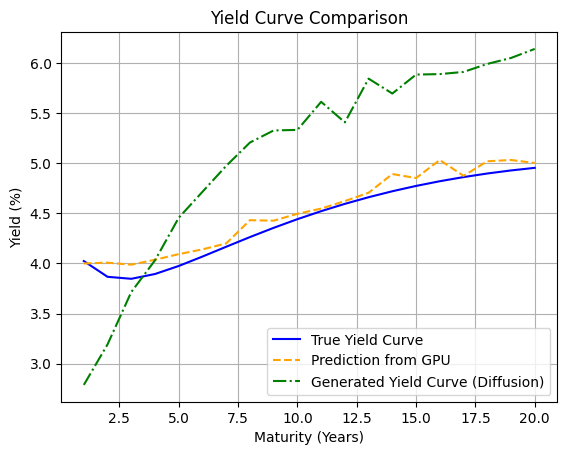

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# maturities should be an array of 1 to 20
maturities = np.arange(1, 21)

# Plot the true yield curve
plt.plot(maturities, true_yield[0], label='True Yield Curve', linestyle='-', color='blue')

# Plot the predicted yield curve from GPU
plt.plot(maturities, predicted_yield[0], label='Prediction from GPU', linestyle='--', color='orange')

# Plot the diffusion-generated yield curve
plt.plot(maturities, new_curve[0], label='Generated Yield Curve (Diffusion)', linestyle='-.', color='green')


# Labels, title, legend
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve Comparison")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Latent space

In [173]:
latent_space = pd.read_csv('latent_space.csv')